Cross-validated RMSE scores: [-28972.74672885 -22749.10038316 -18437.47503656 -17183.03904249
 -16770.70750268]
Mean RMSE: -20822.61373874605
Cross-validated R² scores: [0.87980986 0.92480488 0.93251752 0.93286812 0.93994937]
Mean R²: 0.9219899508509721


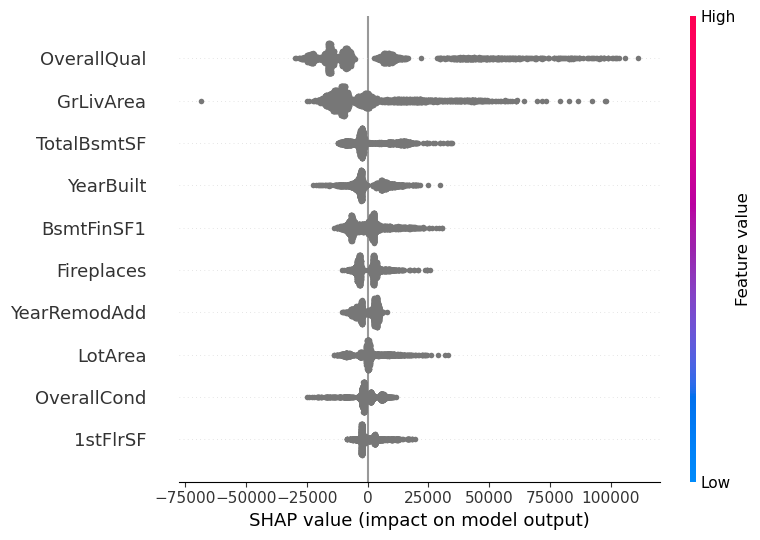

         feature        impact
4    OverallQual  19386.158203
0      GrLivArea  12975.599609
12   TotalBsmtSF   6262.826172
6      YearBuilt   5557.225586
9     BsmtFinSF1   5135.521484
23    Fireplaces   3954.471436
7   YearRemodAdd   3525.432129
3        LotArea   3308.488770
5    OverallCond   3293.727539
13      1stFlrSF   2952.058838


In [9]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# Load the dataset
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)

# Drop PID and empty columns
housing.drop(columns=['PID'], inplace=True)
housing.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = housing.drop('SalePrice', axis=1)
y = housing['SalePrice']

# Preprocessing pipeline for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the XGBoost pipeline
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__reg_lambda': [1, 5, 10],
    'model__reg_alpha': [0, 0.1, 0.5]
}

# Define scorers for cross-validation
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
r2_scorer = 'r2'

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_xgboost, param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X, y)

# Best model from grid search
best_model = grid_search.best_estimator_

# Cross-validated RMSE
cv_rmse_scores = cross_val_score(best_model, X, y, cv=5, scoring=rmse_scorer)
print(f"Cross-validated RMSE scores: {cv_rmse_scores}")
print(f"Mean RMSE: {np.mean(cv_rmse_scores)}")

# Cross-validated R²
cv_r2_scores = cross_val_score(best_model, X, y, cv=5, scoring=r2_scorer)
print(f"Cross-validated R² scores: {cv_r2_scores}")
print(f"Mean R²: {np.mean(cv_r2_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(best_model, X, y, cv=5)

# Use SHAP to explain the model's predictions
# Extract the fitted XGBoost model
xgboost_model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

# Transform the data
X_transformed = preprocessor.transform(X)

# Extract feature names after transformation
transformed_feature_names = (
    list(preprocessor.transformers_[0][1].get_feature_names_out(numeric_features)) +
    list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))
)

# Initialize SHAP explainer
explainer = shap.Explainer(xgboost_model)

# Calculate SHAP values
shap_values = explainer(X_transformed)

# Plot summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_transformed, feature_names=transformed_feature_names,plot_type='bar', max_display=10)
plt.show()

# Function to recommend feature changes for maximum price
def recommend_features(feature_names, shap_values, top_n=10):
    feature_impact = np.mean(np.abs(shap_values.values), axis=0)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'impact': feature_impact
    }).sort_values(by='impact', ascending=False)

    return feature_importance.head(top_n)

# Get top feature recommendations
top_features = recommend_features(transformed_feature_names, shap_values)
print(top_features)


Cross-validated RMSE scores: [-28972.74672885 -22749.10038316 -18437.47503656 -17183.03904249
 -16770.70750268]
Mean RMSE: -20822.61373874605
Cross-validated R² scores: [0.87980986 0.92480488 0.93251752 0.93286812 0.93994937]
Mean R²: 0.9219899508509721


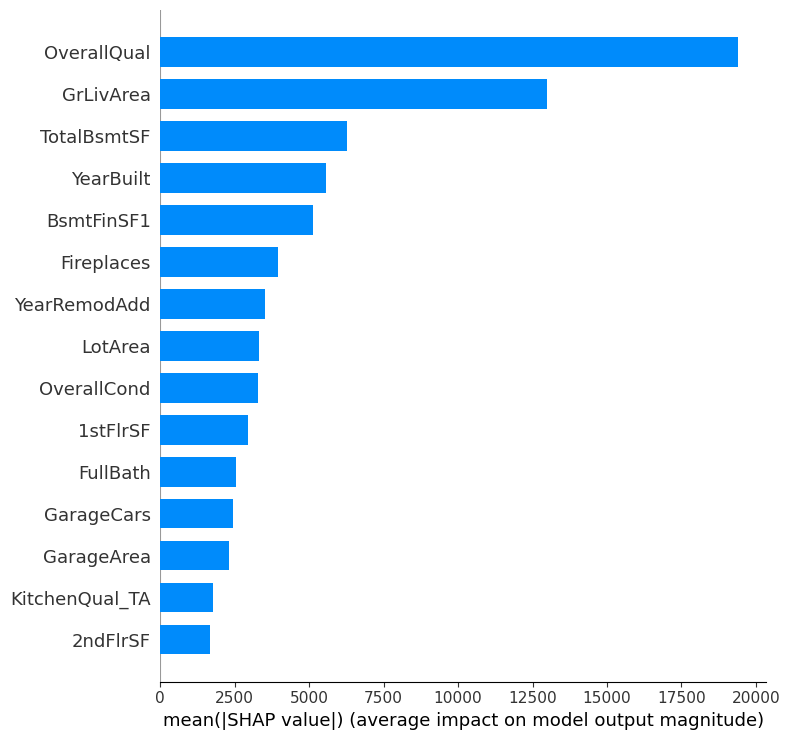

            feature        impact
4       OverallQual  19386.158203
0         GrLivArea  12975.599609
12      TotalBsmtSF   6262.826172
6         YearBuilt   5557.225586
9        BsmtFinSF1   5135.521484
23       Fireplaces   3954.471436
7      YearRemodAdd   3525.432129
3           LotArea   3308.488770
5       OverallCond   3293.727539
13         1stFlrSF   2952.058838
18         FullBath   2537.310303
25       GarageCars   2426.593994
26       GarageArea   2299.033691
232  KitchenQual_TA   1753.156006
14         2ndFlrSF   1653.185669


In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt

# Load the dataset
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)

# Drop PID and empty columns
housing.drop(columns=['PID'], inplace=True)
housing.dropna(axis=1, how='all', inplace=True)

# Define features and target variable
X = housing.drop('SalePrice', axis=1)
y = housing['SalePrice']

# Preprocessing pipeline for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the XGBoost pipeline
pipeline_xgboost = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__reg_lambda': [1, 5, 10],
    'model__reg_alpha': [0, 0.1, 0.5]
}

# Define scorers for cross-validation
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
r2_scorer = 'r2'

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline_xgboost, param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
grid_search.fit(X, y)

# Best model from grid search
best_model = grid_search.best_estimator_

# Cross-validated RMSE
cv_rmse_scores = cross_val_score(best_model, X, y, cv=5, scoring=rmse_scorer)
print(f"Cross-validated RMSE scores: {cv_rmse_scores}")
print(f"Mean RMSE: {np.mean(cv_rmse_scores)}")

# Cross-validated R²
cv_r2_scores = cross_val_score(best_model, X, y, cv=5, scoring=r2_scorer)
print(f"Cross-validated R² scores: {cv_r2_scores}")
print(f"Mean R²: {np.mean(cv_r2_scores)}")

# Perform cross-validation predictions
cv_predictions = cross_val_predict(best_model, X, y, cv=5)

# Use SHAP to explain the model's predictions
# Extract the fitted XGBoost model
xgboost_model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

# Transform the data
X_transformed = preprocessor.transform(X)

# Extract feature names after transformation
transformed_feature_names = (
    list(preprocessor.transformers_[0][1].get_feature_names_out(numeric_features)) +
    list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))
)

# Initialize SHAP explainer
explainer = shap.Explainer(xgboost_model)

# Calculate SHAP values
shap_values = explainer(X_transformed)

# Plot summary as bar chart
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_transformed, feature_names=transformed_feature_names, plot_type='bar', max_display=15)
plt.show()

# Function to recommend feature changes for maximum price
def recommend_features(feature_names, shap_values, top_n=15):
    feature_impact = np.mean(np.abs(shap_values.values), axis=0)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'impact': feature_impact
    }).sort_values(by='impact', ascending=False)

    return feature_importance.head(top_n)

# Get top feature recommendations
top_features = recommend_features(transformed_feature_names, shap_values)
print(top_features)




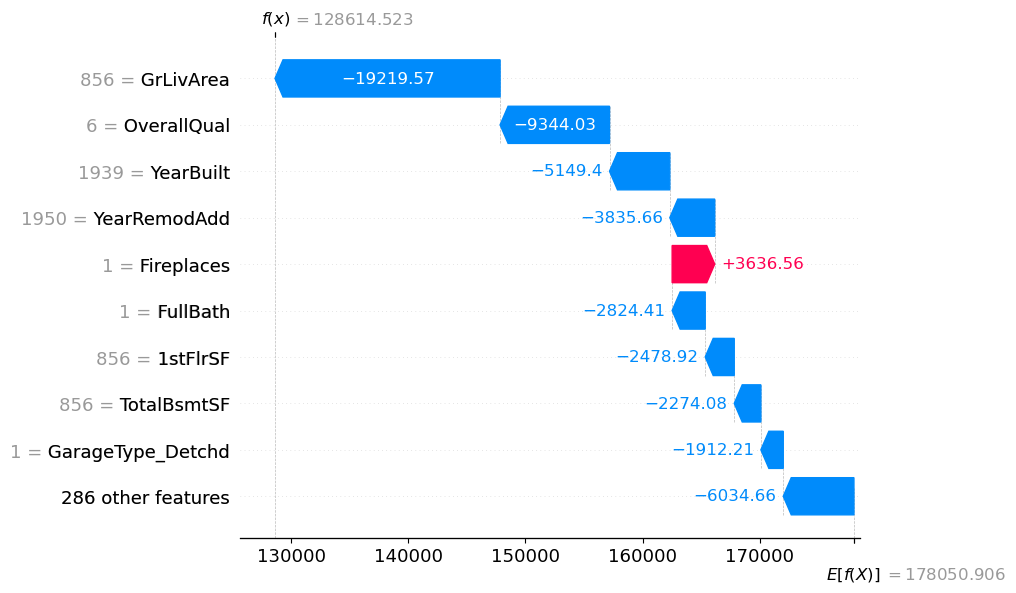

In [18]:


# Select an instance for the waterfall plot (e.g., the first instance)
instance_index = 0
shap_values_instance = shap_values[instance_index]

# Update feature names in shap_values_instance
shap_values_instance.feature_names = transformed_feature_names

# Plot waterfall plot for the selected instance
shap.waterfall_plot(shap_values_instance)